In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
BASE_DIR = '/content/drive/MyDrive/MLL/MLL-Brain_Tumor_Project/Brain Tumor data'
TRAIN_DIR = os.path.join(BASE_DIR, 'Training')
TEST_DIR  = os.path.join(BASE_DIR, 'Testing')

if os.path.exists(BASE_DIR):
    print(f"Found base folder: {BASE_DIR}")
    print("Contents:", os.listdir(BASE_DIR))
else:
    raise FileNotFoundError(f"Folder not found at {BASE_DIR}")

Found base folder: /content/drive/MyDrive/MLL/MLL-Brain_Tumor_Project/Brain Tumor data
Contents: ['Training', 'Testing']


No. Of Images per Class

*Training data distribution*

Number of images per category in Training directory:
meningioma: 1339
glioma: 1321
notumor: 1595
pituitary: 1457


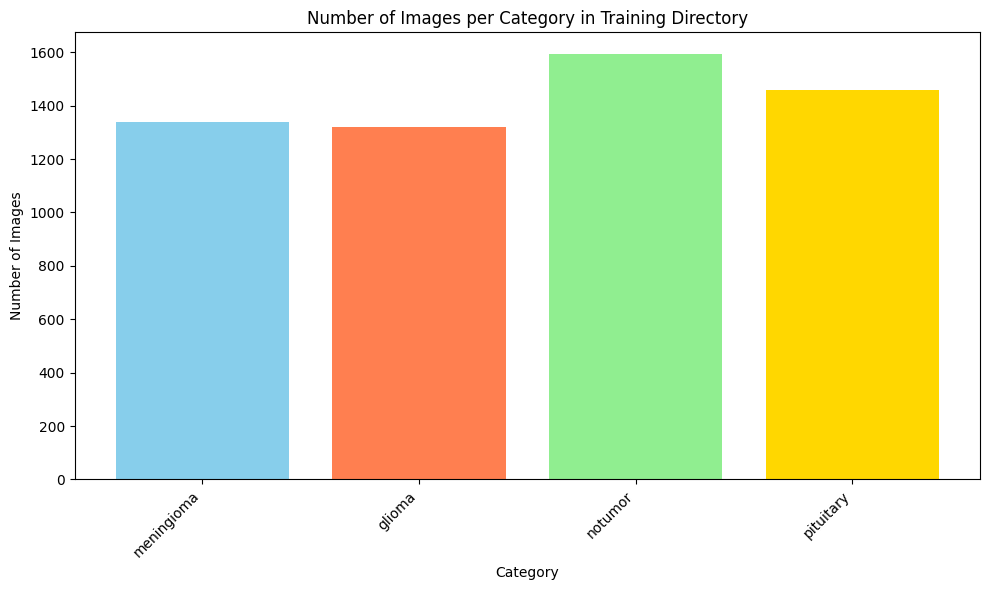

In [4]:
categories = os.listdir(TRAIN_DIR)
image_counts = {}

for category in categories:
    category_path = os.path.join(TRAIN_DIR, category)
    count = 0
    if os.path.isdir(category_path):
        for item in os.listdir(category_path):
            item_path = os.path.join(category_path, item)
            if os.path.isfile(item_path):
                ext = os.path.splitext(item_path)[1].lower()
                if ext in ('.jpg', '.jpeg', '.png', '.gif'):
                    count += 1
    image_counts[category] = count

print("Number of images per category in Training directory:")
for category, count in image_counts.items():
    print(f"{category}: {count}")

plt.figure(figsize=(10, 6))
plt.bar(image_counts.keys(), image_counts.values(), color=['skyblue', 'coral', 'lightgreen', 'gold'])
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Images per Category in Training Directory')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

*Testing data distribution*

Number of images per category in Testing directory:
glioma: 300
notumor: 405
pituitary: 300
meningioma: 306


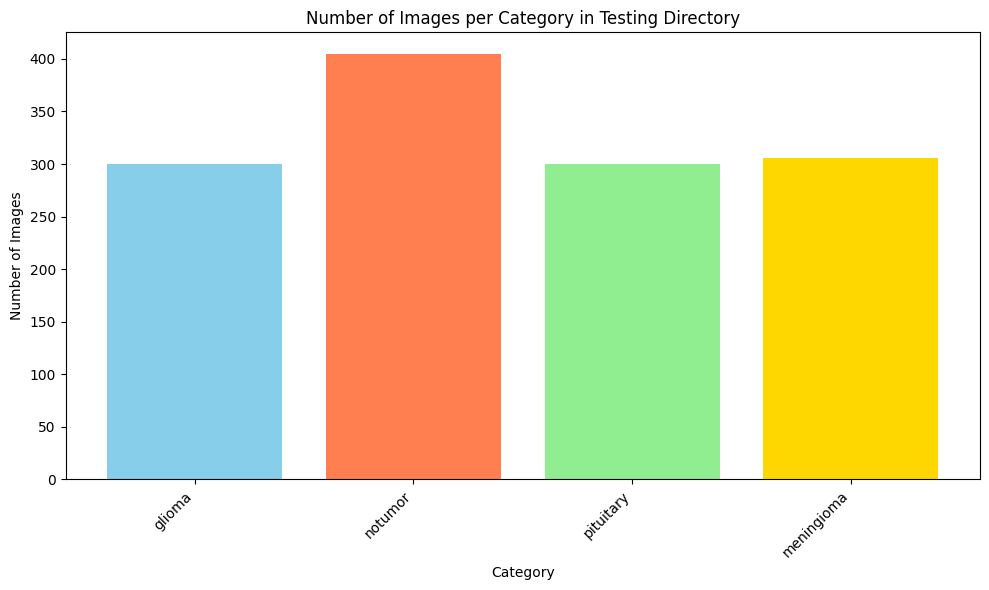

In [7]:
categories = os.listdir(TEST_DIR)
image_counts = {}

for category in categories:
    category_path = os.path.join(TEST_DIR, category)
    count = 0
    if os.path.isdir(category_path):
        for item in os.listdir(category_path):
            item_path = os.path.join(category_path, item)
            if os.path.isfile(item_path):
                ext = os.path.splitext(item_path)[1].lower()
                if ext in ('.jpg', '.jpeg', '.png', '.gif'):
                    count += 1
    image_counts[category] = count

print("Number of images per category in Testing directory:")
for category, count in image_counts.items():
    print(f"{category}: {count}")

plt.figure(figsize=(10, 6))
plt.bar(image_counts.keys(), image_counts.values(), color=['skyblue', 'coral', 'lightgreen', 'gold'])
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Images per Category in Testing Directory')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Training Categories: ['meningioma', 'glioma', 'notumor', 'pituitary']


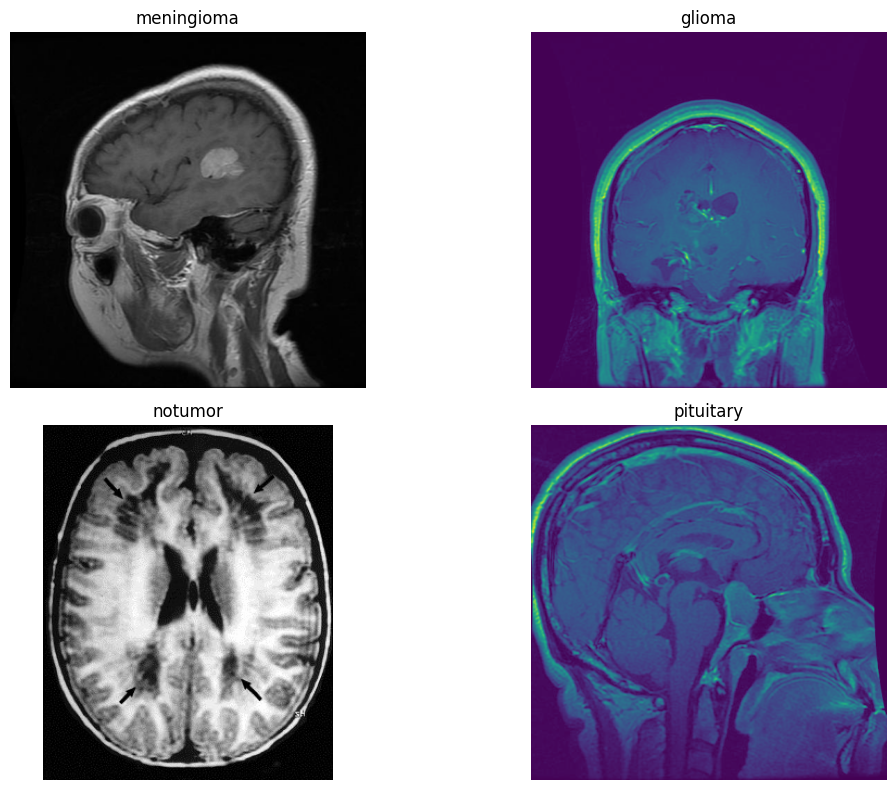

In [11]:
categories = os.listdir(TRAIN_DIR)
print("\nTraining Categories:", categories)

plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    category_path = os.path.join(TRAIN_DIR, category)
    images = os.listdir(category_path)
    random_image = random.choice(images)
    img_path = os.path.join(category_path, random_image)

    img = mpimg.imread(img_path)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

In [6]:
preprocess_func = resnet_preprocess

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_func,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.20,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_func,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_func
)


In [7]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


augmented sample images

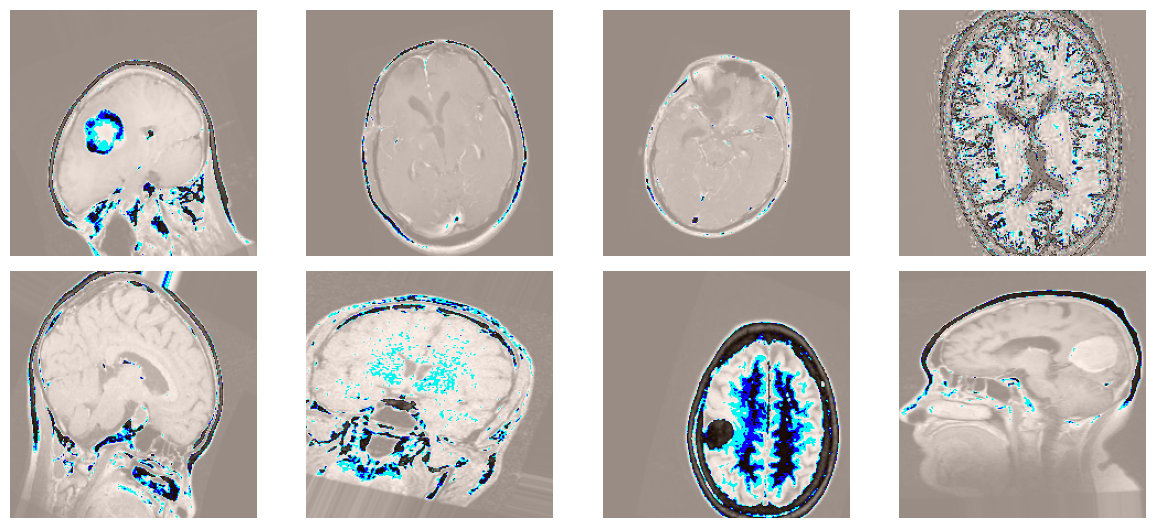

In [8]:
augmented_images, augmented_labels = next(train_generator)

plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(3, 4, i+1)
    plt.imshow(augmented_images[i].astype("uint8"))
    plt.axis("off")

plt.tight_layout()
plt.show()

Restnet50

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
NUM_CLASSES = len(os.listdir(TRAIN_DIR))

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
checkpoint = ModelCheckpoint(
    '/content/best_resnet50_brain_tumor.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.3036 - loss: 1.6987
Epoch 1: val_accuracy improved from -inf to 0.52410, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 116s 725ms/step - accuracy: 0.3039 - loss: 1.6973 - val_accuracy: 0.5241 - val_loss: 1.2057
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.4357 - loss: 1.2483
Epoch 2: val_accuracy improved from 0.52410 to 0.57844, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 608ms/step - accuracy: 0.4358 - loss: 1.2480 - val_accuracy: 0.5784 - val_loss: 1.1345
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.5251 - loss: 1.0732
Epoch 3: val_accuracy improved from 0.57844 to 0.59684, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 620ms/step - accuracy: 0.5252 - loss: 1.0730 - val_accuracy: 0.5968 - val_loss: 1.0898
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.5779 - loss: 0.9591
Epoch 4: val_accuracy did not improve from 0.59684
143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 606ms/step - accuracy: 0.5779 - loss: 0.9591 - val_accuracy: 0.5960 - val_loss: 1.0768
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.6157 - loss: 0.9017
Epoch 5: val_accuracy improved from 0.59684 to 0.60123, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 88s 616ms/step - accuracy: 0.6157 - loss: 0.9016 - val_accuracy: 0.6012 - val_loss: 1.0372
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.6314 - loss: 0.8643
Epoch 6: val_accuracy improved from 0.60123 to 0.63103, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 605ms/step - accuracy: 0.6315 - loss: 0.8642 - val_accuracy: 0.6310 - val_loss: 1.0198
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.6623 - loss: 0.8205
Epoch 7: val_accuracy did not improve from 0.63103
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 620ms/step - accuracy: 0.6623 - loss: 0.8204 - val_accuracy: 0.6205 - val_loss: 1.0257
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.6661 - loss: 0.7882
Epoch 8: val_accuracy improved from 0.63103 to 0.63278, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 623ms/step - accuracy: 0.6661 - loss: 0.7882 - val_accuracy: 0.6328 - val_loss: 0.9952
Epoch 9/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.6753 - loss: 0.7714
Epoch 9: val_accuracy did not improve from 0.63278
143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 608ms/step - accuracy: 0.6753 - loss: 0.7713 - val_accuracy: 0.6223 - val_loss: 0.9984
Epoch 10/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.7061 - loss: 0.7421
Epoch 10: val_accuracy did not improve from 0.63278
143/143 ━━━━━━━━━━━━━━━━━━━━ 88s 614ms/step - accuracy: 0.7061 - loss: 0.7420 - val_accuracy: 0.6214 - val_loss: 0.9921
Epoch 11/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.6952 - loss: 0.7352
Epoch 11: val_accuracy did not improve from 0.63278
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 620ms/step - accuracy: 0.6953 - loss: 0.7351 - val_accuracy: 0.6188 - val_loss: 1.0070
Epoch 12/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.7049 - loss: 0.7143
Epoch 12: 

143/143 ━━━━━━━━━━━━━━━━━━━━ 88s 615ms/step - accuracy: 0.7049 - loss: 0.7142 - val_accuracy: 0.6477 - val_loss: 0.9790
Epoch 13/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.7174 - loss: 0.6961
Epoch 13: val_accuracy did not improve from 0.64768
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 618ms/step - accuracy: 0.7174 - loss: 0.6961 - val_accuracy: 0.6459 - val_loss: 0.9579
Epoch 14/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.7210 - loss: 0.6826
Epoch 14: val_accuracy improved from 0.64768 to 0.66082, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 88s 617ms/step - accuracy: 0.7210 - loss: 0.6827 - val_accuracy: 0.6608 - val_loss: 0.9408
Epoch 15/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.7362 - loss: 0.6887
Epoch 15: val_accuracy did not improve from 0.66082
143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 608ms/step - accuracy: 0.7362 - loss: 0.6886 - val_accuracy: 0.6319 - val_loss: 0.9919


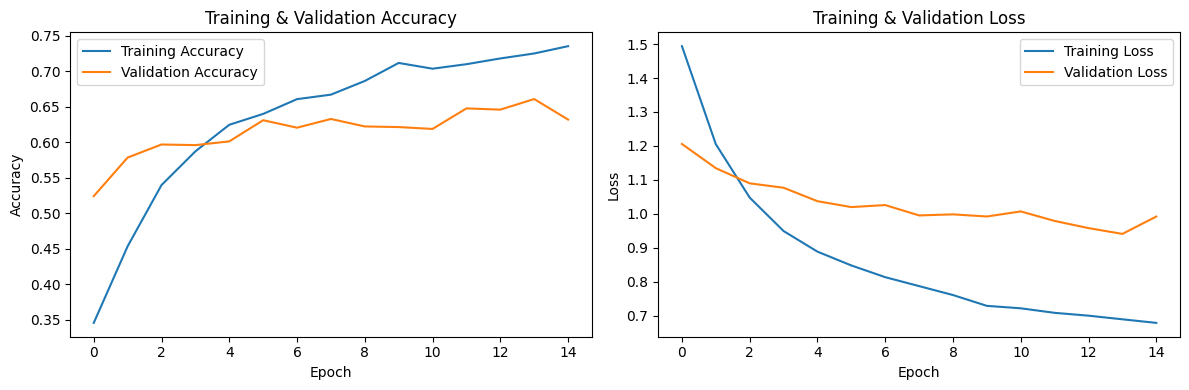

In [ ]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Fine Tuning**

In [ ]:

for layer in base_model.layers[-50:]:
    layer.trainable = True
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.5960 - loss: 1.4291
Epoch 1: val_accuracy improved from 0.66082 to 0.68361, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 135s 771ms/step - accuracy: 0.5968 - loss: 1.4255 - val_accuracy: 0.6836 - val_loss: 0.9137
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.7843 - loss: 0.5471
Epoch 2: val_accuracy improved from 0.68361 to 0.74145, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 92s 639ms/step - accuracy: 0.7844 - loss: 0.5469 - val_accuracy: 0.7415 - val_loss: 0.7375
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8312 - loss: 0.4423
Epoch 3: val_accuracy improved from 0.74145 to 0.76775, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 92s 640ms/step - accuracy: 0.8313 - loss: 0.4421 - val_accuracy: 0.7677 - val_loss: 0.6386
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8554 - loss: 0.3688
Epoch 4: val_accuracy improved from 0.76775 to 0.80105, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 92s 641ms/step - accuracy: 0.8553 - loss: 0.3689 - val_accuracy: 0.8011 - val_loss: 0.5630
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.8774 - loss: 0.3301
Epoch 5: val_accuracy improved from 0.80105 to 0.80719, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 95s 664ms/step - accuracy: 0.8774 - loss: 0.3301 - val_accuracy: 0.8072 - val_loss: 0.5296
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.8863 - loss: 0.3039
Epoch 6: val_accuracy improved from 0.80719 to 0.82033, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 692ms/step - accuracy: 0.8864 - loss: 0.3038 - val_accuracy: 0.8203 - val_loss: 0.5471
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.8893 - loss: 0.2896
Epoch 7: val_accuracy did not improve from 0.82033
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 648ms/step - accuracy: 0.8893 - loss: 0.2895 - val_accuracy: 0.8054 - val_loss: 0.5514
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.8996 - loss: 0.2649
Epoch 8: val_accuracy improved from 0.82033 to 0.84137, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 92s 643ms/step - accuracy: 0.8996 - loss: 0.2648 - val_accuracy: 0.8414 - val_loss: 0.4930
Epoch 9/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.9163 - loss: 0.2159
Epoch 9: val_accuracy did not improve from 0.84137
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 647ms/step - accuracy: 0.9162 - loss: 0.2160 - val_accuracy: 0.8361 - val_loss: 0.5401
Epoch 10/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.9238 - loss: 0.2012
Epoch 10: val_accuracy did not improve from 0.84137
143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 635ms/step - accuracy: 0.9238 - loss: 0.2012 - val_accuracy: 0.8370 - val_loss: 0.5209


Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9218 - loss: 0.2160
Epoch 1: val_accuracy did not improve from 0.84137
143/143 ━━━━━━━━━━━━━━━━━━━━ 134s 760ms/step - accuracy: 0.9218 - loss: 0.2161 - val_accuracy: 0.8230 - val_loss: 0.5616
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.9223 - loss: 0.2131
Epoch 2: val_accuracy did not improve from 0.84137
143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 635ms/step - accuracy: 0.9223 - loss: 0.2131 - val_accuracy: 0.8379 - val_loss: 0.4988
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9165 - loss: 0.2237
Epoch 3: val_accuracy improved from 0.84137 to 0.85188, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 637ms/step - accuracy: 0.9165 - loss: 0.2236 - val_accuracy: 0.8519 - val_loss: 0.4661
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9276 - loss: 0.1961
Epoch 4: val_accuracy did not improve from 0.85188
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 624ms/step - accuracy: 0.9276 - loss: 0.1961 - val_accuracy: 0.8449 - val_loss: 0.4591
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.9329 - loss: 0.1755
Epoch 5: val_accuracy improved from 0.85188 to 0.85714, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 695ms/step - accuracy: 0.9329 - loss: 0.1755 - val_accuracy: 0.8571 - val_loss: 0.4630
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.9411 - loss: 0.1573
Epoch 6: val_accuracy improved from 0.85714 to 0.85977, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 109s 763ms/step - accuracy: 0.9411 - loss: 0.1574 - val_accuracy: 0.8598 - val_loss: 0.4797
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.9383 - loss: 0.1599
Epoch 7: val_accuracy improved from 0.85977 to 0.87905, saving model to /content/best_resnet50_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 117s 817ms/step - accuracy: 0.9384 - loss: 0.1599 - val_accuracy: 0.8791 - val_loss: 0.4213
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.9352 - loss: 0.1634
Epoch 8: val_accuracy did not improve from 0.87905
143/143 ━━━━━━━━━━━━━━━━━━━━ 112s 784ms/step - accuracy: 0.9352 - loss: 0.1633 - val_accuracy: 0.8642 - val_loss: 0.4803
Epoch 9/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.9474 - loss: 0.1431
Epoch 9: val_accuracy did not improve from 0.87905
143/143 ━━━━━━━━━━━━━━━━━━━━ 113s 794ms/step - accuracy: 0.9474 - loss: 0.1431 - val_accuracy: 0.8712 - val_loss: 0.4420
Epoch 10/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.9559 - loss: 0.1187
Epoch 10: val_accuracy did not improve from 0.87905
143/143 ━━━━━━━━━━━━━━━━━━━━ 110s 771ms/step - accuracy: 0.9558 - loss: 0.1188 - val_accuracy: 0.8624 - val_loss: 0.4742
Epoch 11/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.9459 - loss: 0.1394
Epoch 11

143/143 ━━━━━━━━━━━━━━━━━━━━ 118s 824ms/step - accuracy: 0.9517 - loss: 0.1352 - val_accuracy: 0.8834 - val_loss: 0.4395


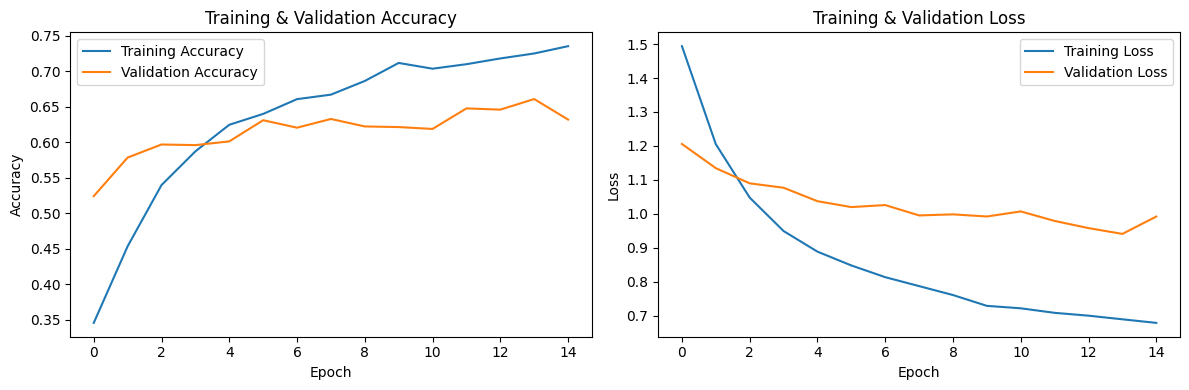

41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 411ms/step

🧾 Classification Report:

              precision    recall  f1-score   support

      glioma       0.94      0.78      0.85       300
  meningioma       0.81      0.82      0.81       306
     notumor       0.93      0.99      0.96       405
   pituitary       0.90      0.97      0.94       300

    accuracy                           0.90      1311
   macro avg       0.90      0.89      0.89      1311
weighted avg       0.90      0.90      0.90      1311



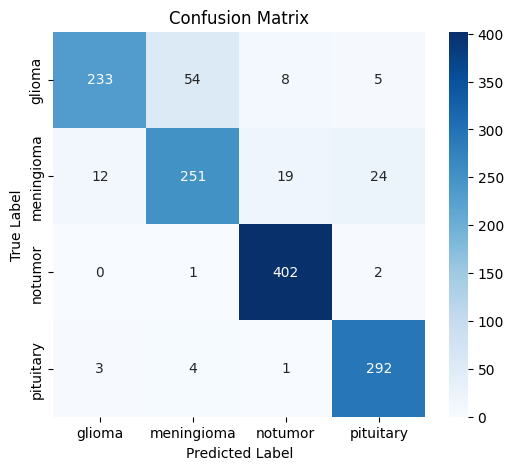

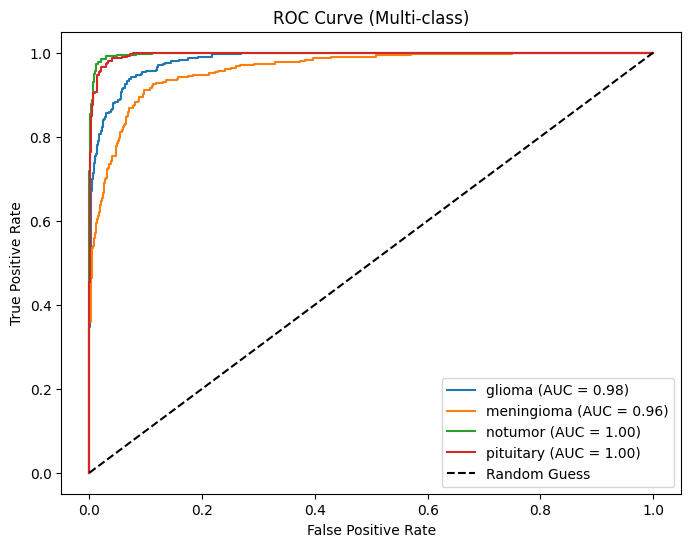

In [ ]:
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint, early_stop]
)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
target_names = list(test_generator.class_indices.keys())

print("\n🧾 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true, classes=range(len(target_names)))
fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(target_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(len(target_names)):
    plt.plot(fpr[i], tpr[i], label=f'{target_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve (Multi-class)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"\n Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.8411 - loss: 0.5025

 Test Loss: 0.3287
Test Accuracy: 0.8986


**Fine Tuned Curve**

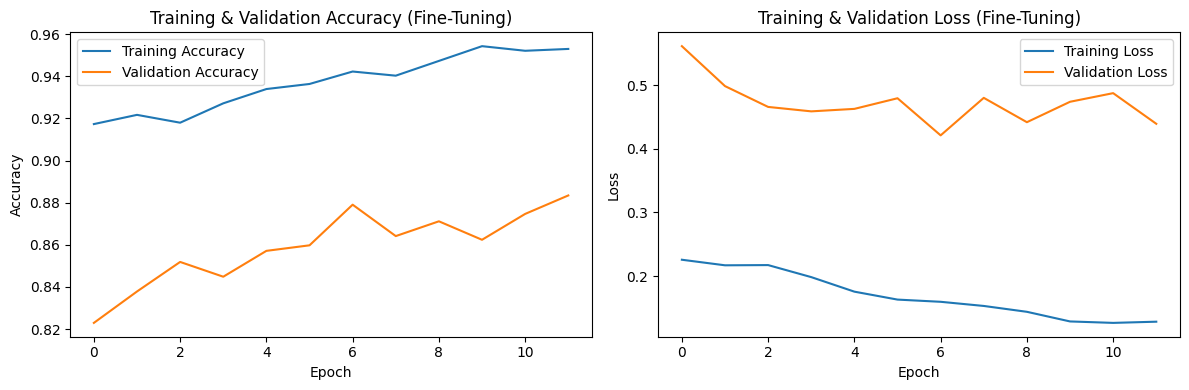

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy (Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss (Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
